# Computing array directional resolving power

This notebook can be used to estimate the average directional resolving power for particular deployment scenarios.

In [1]:
import project
import geometry
import pygmt
import pyproj

To compute the directional resolving power of an array, we assume that an array comprises two linear sub-arrays and that the capacity of each sub-array to  resolve the slowness of a wave is proportional to the cosine of the angle between the slowness vector and the orientation of the sub-array (i.e., a sub-array can perfectly resolve a wave propagating parallel to it and has no resolving power for a wave propagating perpendicular).

The cell below defines the deployment scenario. The center of each array is defined in the `mini_arrays` variable and the orientation of the sub-arrays is defined by `az_0` and `d_az`. The azimuth of the sub-arrays are `az_0 - d_az` and `az_0 + d_az`, respectively.

In [33]:
az_0 = 45
d_az = 45

# # SCENARIO A
# scenario = 'A'
# mini_arrays = np.array([
#     [-71.75, -34], # Southern
#     [-71.25, -32.25],
#     [-71.4, -30.5], # Central
#     [-71, -28.75],
#     [-70.75, -27] # Northern
# ])

# # SCENARIO B
# scenario = 'B'
# mini_arrays = np.array([
#     [-71.55, -33.5], # Southern
#     [-71.4, -30.5], # Central
#     [-70.75, -27.5] # Northern
# ])


# SCENARIO C
scenario = 'C'
mini_arrays = np.array([
    [-71.45, -32.9], # Southern N
    [-71.55, -33.5], # Southern S
    [-71.4, -30.2], # Central N
    [-71.4, -30.8], # Central S
    [-70.75, -27.5], # Northern N
    [-70.95, -28.1] # Northern S
])


arm_orientations = np.array([[az_0-d_az, az_0+d_az] for array in mini_arrays])
sub_scenario = f''

## Compute resolving power

This cell computes the average resolving power for hypothetical events distributed on a grid.

In [34]:
geod = pyproj.Geod(ellps='WGS84')

grid = np.mgrid[-74: -68: 101j, -35: -26: 101j]
resolution = np.zeros(grid.shape[1:])

for (a_lon, a_lat), orientations in zip(mini_arrays, arm_orientations):
    arr = np.stack([
        np.tile(a_lon, [101, 101]),
        np.tile(a_lat, [101, 101])
    ])
    for orientation in orientations:
        az, baz, dist = geod.inv(*arr, *grid)
        idx = np.where(dist < 200e3)
        resolution[idx] += np.abs(np.cos(np.radians(baz[idx] - orientation)))
        # resolution += np.abs(np.cos(np.radians(baz - orientation)))

# resolution /= np.prod(arm_orientations.shape)
# resolution /= np.max(np.abs(resolution))
resolution /= 6

And this cell plots the resolution map

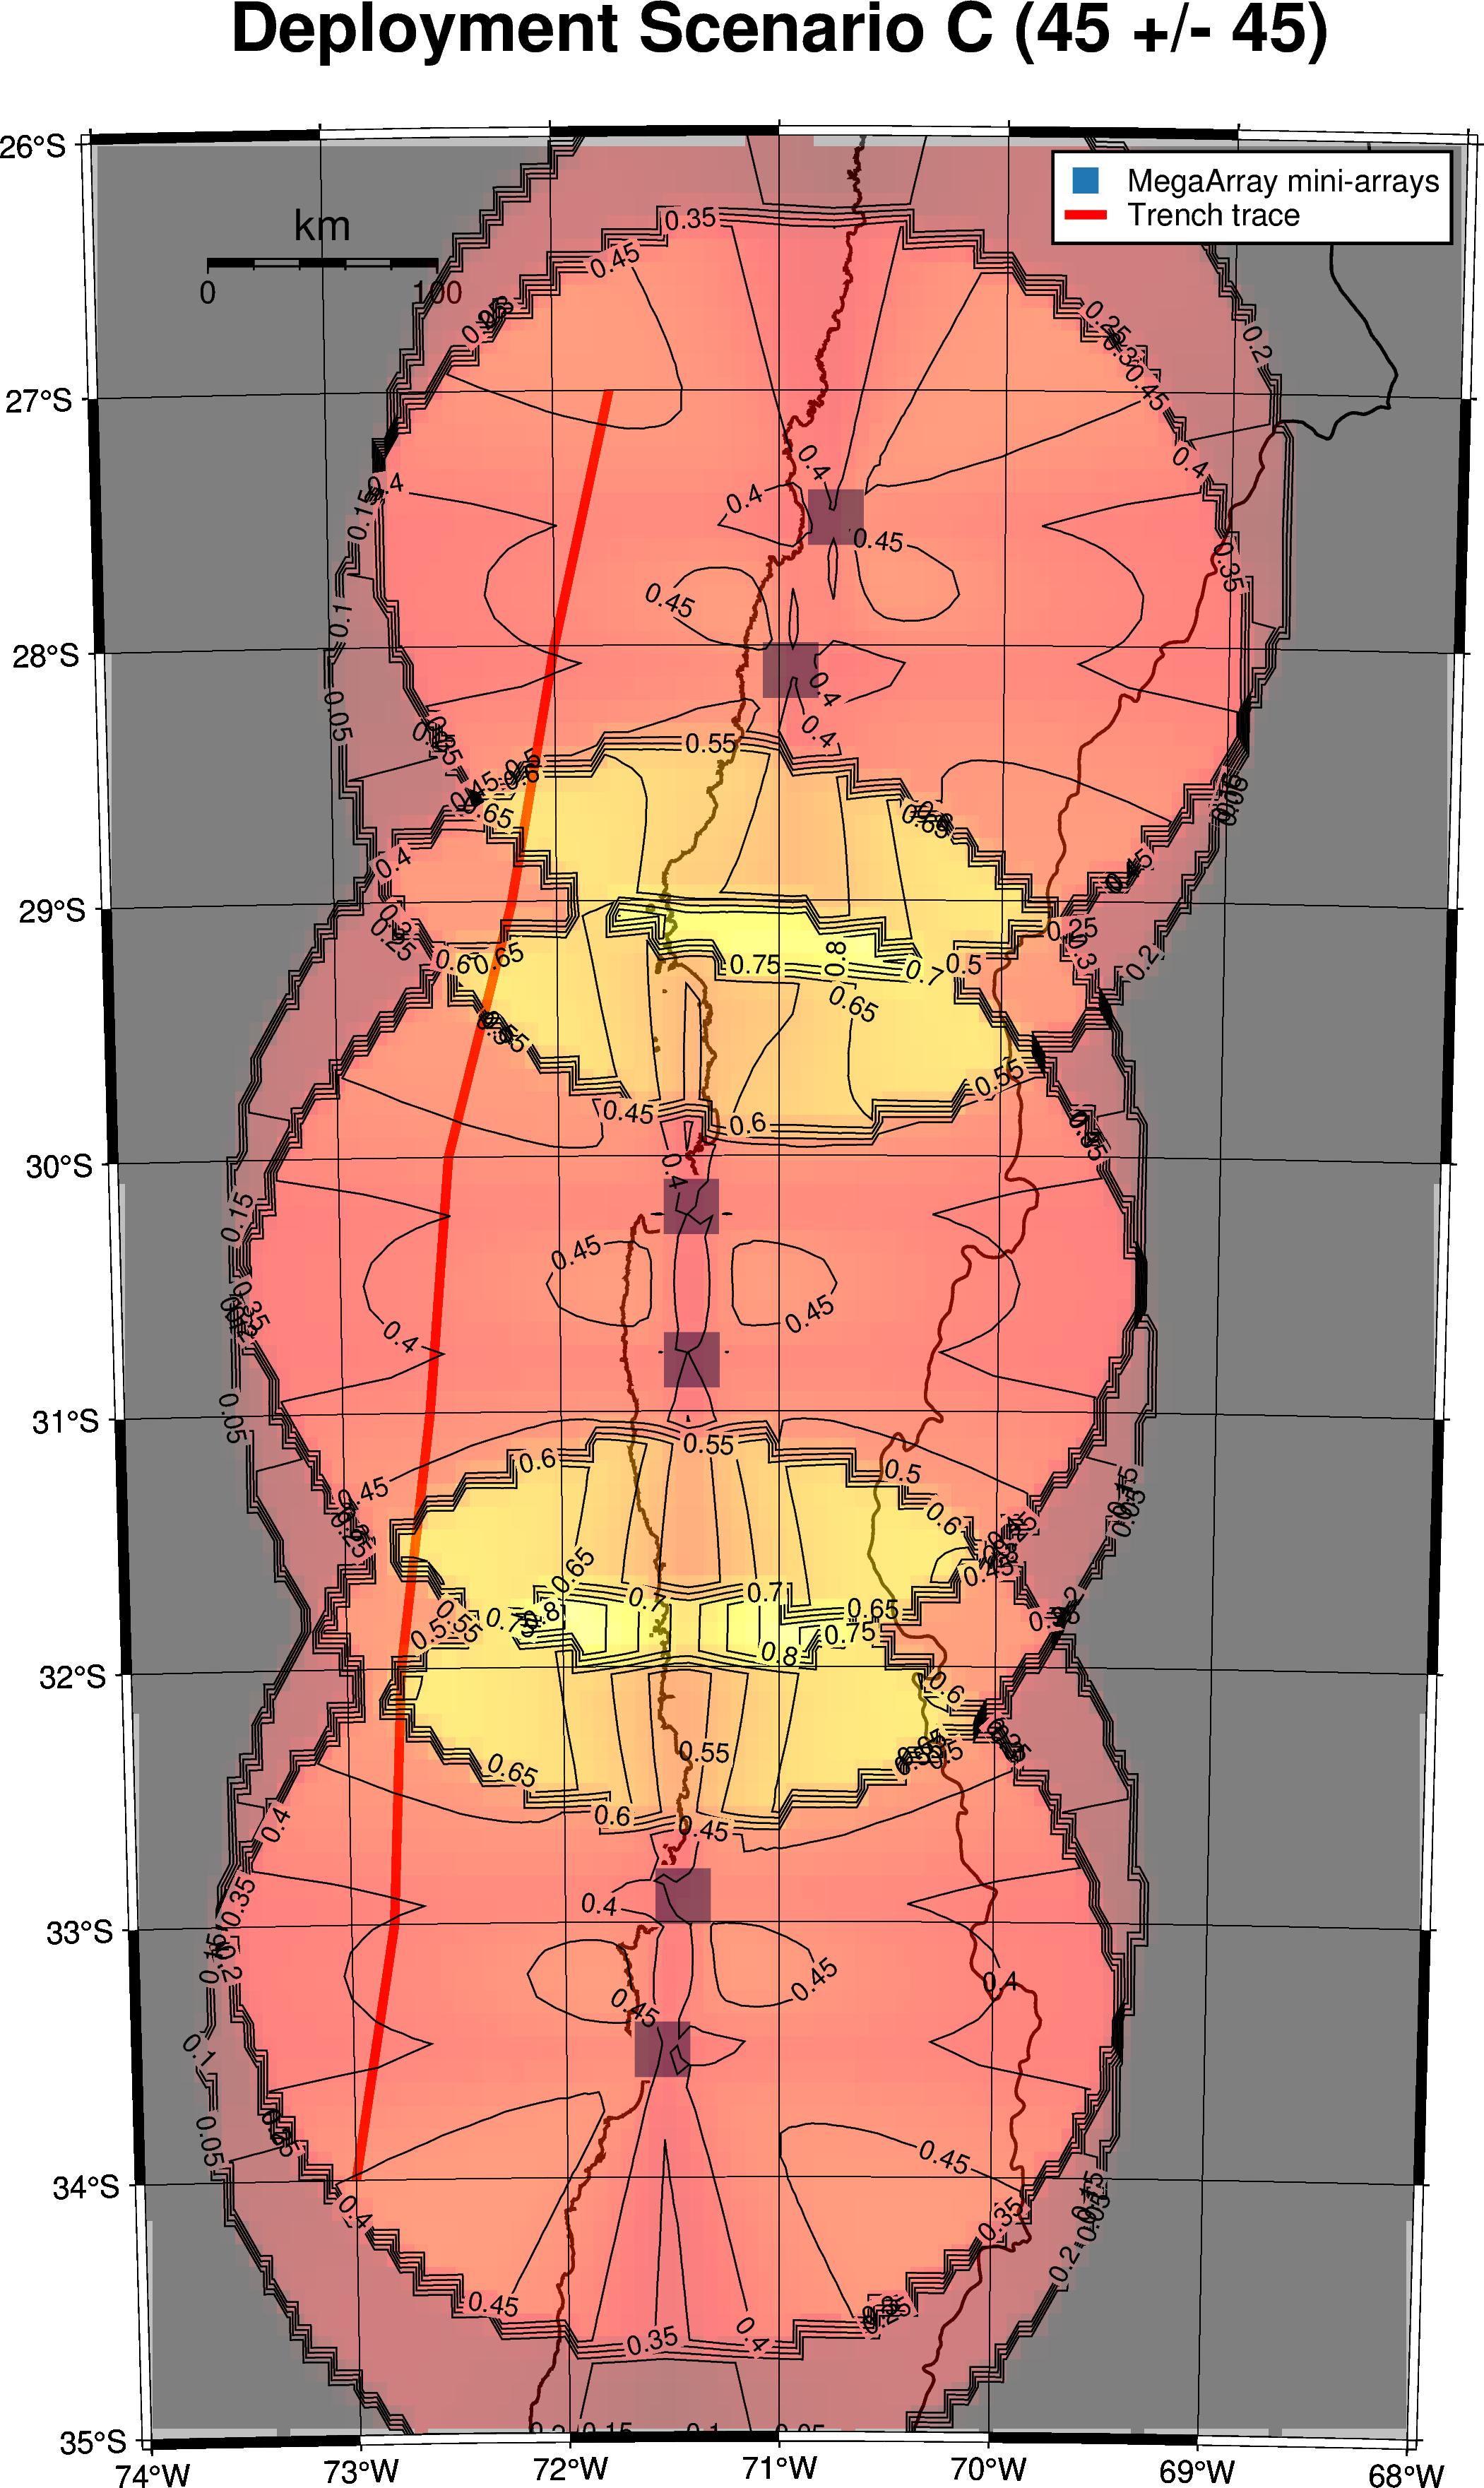

In [35]:
FIGURE_WIDTH = 6.5 * 2.54
PLOT_RELIEF = False
LON_MIN, LON_MAX = -74, -68
LAT_MIN, LAT_MAX = -35, -26
LAND_COLOR = '#666666'
WATER_COLOR = 'skyblue'

lon0 = (LON_MIN + LON_MAX) / 2
lat0 = (LAT_MIN + LAT_MAX) / 2

region = f'{LON_MIN}/{LON_MAX}/{LAT_MIN}/{LAT_MAX}'
projection = f'B{lon0}/{lat0}/{LAT_MIN}/{LAT_MAX}/{FIGURE_WIDTH}c'

fig = pygmt.Figure()
if PLOT_RELIEF is True:
    grd = pygmt.datasets.load_earth_relief(
        resolution='01m',
        region=region
    )
    fig.grdimage(
        grid=grd,
        projection=projection,
        cmap='geo',
        region=region,
        frame='ag'
    )
    LAND_COLOR = WATER_COLOR = None
else:
    fig.basemap(
        projection=projection,
        region=region,
        frame='ag'
    )
fig.coast(
    borders='1/1p',
    shorelines='1/1p',
    # land=LAND_COLOR,
    # water=WATER_COLOR,
    frame=['ag', f'+t"Deployment Scenario {scenario} ({az_0} +/- {d_az})"'],
    map_scale='g-73/-26.5+w100k+f+lkm'
)

fig.plot(
    x=mini_arrays[:, 0],
    y=mini_arrays[:, 1],
    style='s1c',
    color=project.TAB_BLUE,
    pen='1p,white',
    label='"MegaArray mini-arrays"+S0.5c'
)
fig.plot(
    x=project.TRENCH_TRACE.xy[0],
    y=project.TRENCH_TRACE.xy[1],
    pen='3p,red',
    label='Trench trace'
)


if PLOT_RELIEF is False:
    fig.plot(
        x=project.TRENCH_TRACE.xy[0],
        y=project.TRENCH_TRACE.xy[1],
        pen='3p,red'
    )
    x = grid[0].flatten()
    y = grid[1].flatten()
    dx = np.mean(np.diff(grid[0, :, 0]))
    dy = np.mean(np.diff(grid[1, 0, :]))

    grd = pygmt.xyz2grd(
        x=grid[0].flatten(),
        y=grid[1].flatten(),
        z=resolution.flatten(),
        region=f'{x.min()}/{x.max()}/{y.min()}/{y.max()}',
        spacing=(dx, dy)
    )
    pygmt.makecpt(
        cmap='hot',
        series=[0, 1]
    )
    fig.grdimage(
        grid=grd,
        projection=projection,
        region=region,
        transparency=50,
     )

fig.contour(
    projection=projection,
    frame="ag",
    pen="0.5p",
    x=grid[0].flatten(),
    y=grid[1].flatten(),
    z=resolution.flatten(),
    levels=0.05,
    annotation=0.05,
)
fig.legend()
fig.show()
fig.savefig(f'../figures/resolution_scenario_{scenario}_{az_0}_{d_az}.png')